In [717]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler,OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer 
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm.sklearn import LGBMRegressor
import logging
from sklearn.metrics import make_scorer

logging.getLogger('lightgbm').setLevel(logging.ERROR)
seed = np.random.seed(42)

## 1. Data Preprocessing

In [718]:
train = pd.read_csv('resources/train.csv')
test = pd.read_csv('resources/test.csv')

In [719]:
categorical_features = train.select_dtypes(include='object').columns.to_list()
numeric_features = train.select_dtypes(include='number').columns.to_list()
numeric_features = numeric_features[1:-1]
date_features = ['YrSold','MoSold','YearBuilt','YearRemodAdd','GarageYrBlt']

numeric_features = [element for element in numeric_features if element not in date_features]
categorical_features = [element for element in categorical_features if element not in date_features]

features = numeric_features + categorical_features + date_features

In [720]:
preprocessor = ColumnTransformer(
    transformers=[

        ('numeric', Pipeline([
                ('imputer', SimpleImputer(strategy='constant')),
                ('scaler', StandardScaler())
        ]), numeric_features),
        

        ('categorical', Pipeline([
              ('imputer', SimpleImputer(strategy='constant')),
              ('encoder', OrdinalEncoder())
        ]), categorical_features),

        ('date', Pipeline([
                ('imputer', SimpleImputer(strategy='constant'))
        ]),date_features),

    ], 
    verbose=True,
    # remainder='passthrough'
)

In [721]:
train_transformed = preprocessor.fit_transform(train)
train_transformed = pd.DataFrame(train_transformed,columns=features)

[ColumnTransformer] ....... (1 of 3) Processing numeric, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] .......... (3 of 3) Processing date, total=   0.0s


In [722]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [723]:
train_transformed.head(5)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,YrSold,MoSold,YearBuilt,YearRemodAdd,GarageYrBlt
0,0.073375,0.212877,-0.207142,0.651479,-0.517200,0.514104,0.575425,-0.288653,-0.944591,-0.459303,...,3.0,4.0,4.0,8.0,4.0,2008.0,2.0,2003.0,2003.0,2003.0
1,-0.872563,0.645747,-0.091886,-0.071836,2.179628,-0.570750,1.171992,-0.288653,-0.641228,0.466465,...,3.0,4.0,4.0,8.0,4.0,2007.0,5.0,1976.0,1976.0,1976.0
2,0.073375,0.299451,0.073480,0.651479,-0.517200,0.325915,0.092907,-0.288653,-0.301643,-0.313369,...,3.0,4.0,4.0,8.0,4.0,2008.0,9.0,2001.0,2002.0,2001.0
3,0.309859,0.068587,-0.096897,0.651479,-0.517200,-0.570750,-0.499274,-0.288653,-0.061670,-0.687324,...,3.0,4.0,4.0,8.0,0.0,2006.0,2.0,1915.0,1970.0,1998.0
4,0.073375,0.761179,0.375148,1.374795,-0.517200,1.366489,0.463568,-0.288653,-0.174865,0.199680,...,3.0,4.0,4.0,8.0,4.0,2008.0,12.0,2000.0,2000.0,2000.0


## 2. Data Visualization

In [724]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=3, random_state=seed)
# tsne_results = tsne.fit_transform(train_transformed)

In [725]:
# fig = plt.figure(figsize=(20, 15)) 
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], c=train['SalePrice'], cmap='viridis', s=30)

# ax.view_init(elev=20, azim=80)  
# ax.set_title('3D t-SNE Plot for House Market Prices')
# ax.set_xlabel('t-SNE Component 1')
# ax.set_ylabel('t-SNE Component 2')
# ax.set_zlabel('t-SNE Component 3')
# fig.colorbar(scatter, label='Price')
# plt.show()

In [726]:
# tsne = TSNE(n_components=2, random_state=seed)
# tsne_results = tsne.fit_transform(train_transformed)
# plt.figure(figsize=(17,6))
# plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=train['SalePrice'], cmap='viridis')
# plt.title('t-SNE Plot for House Market Prices')
# plt.colorbar(label='Price')
# plt.show()

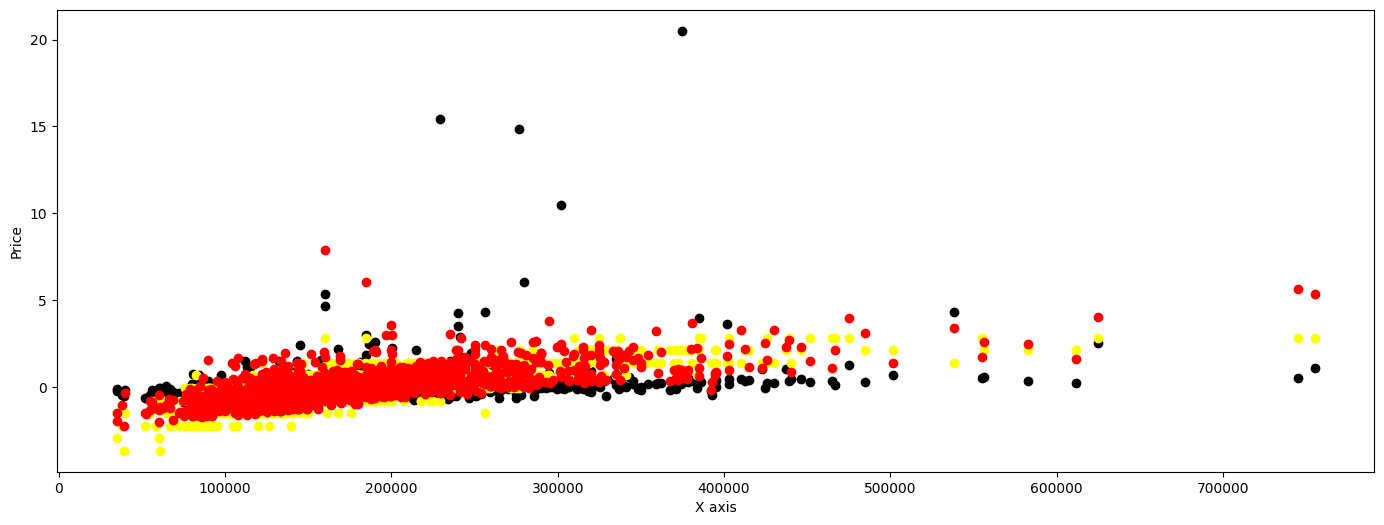

In [727]:
plt.figure(figsize=(17, 6))  
plt.scatter(train['SalePrice'],train_transformed['LotArea'],color='black')
plt.scatter(train['SalePrice'],train_transformed['OverallQual'],color='yellow')
plt.scatter(train['SalePrice'],train_transformed['GrLivArea'],color='red')
plt.xlabel('X axis')
plt.ylabel('Price')
plt.show()

## 2.2 Corelation Analysis

In [728]:
train_hihi = pd.concat([train_transformed, train.iloc[:,-1]], axis=1)
correlation_matrix = train_hihi.corr()

## 2.3 Feature extraction

In [729]:
last_column_correlations = correlation_matrix.iloc[:-1, -1]
most_correlated_features = last_column_correlations.abs().sort_values(ascending=False).index

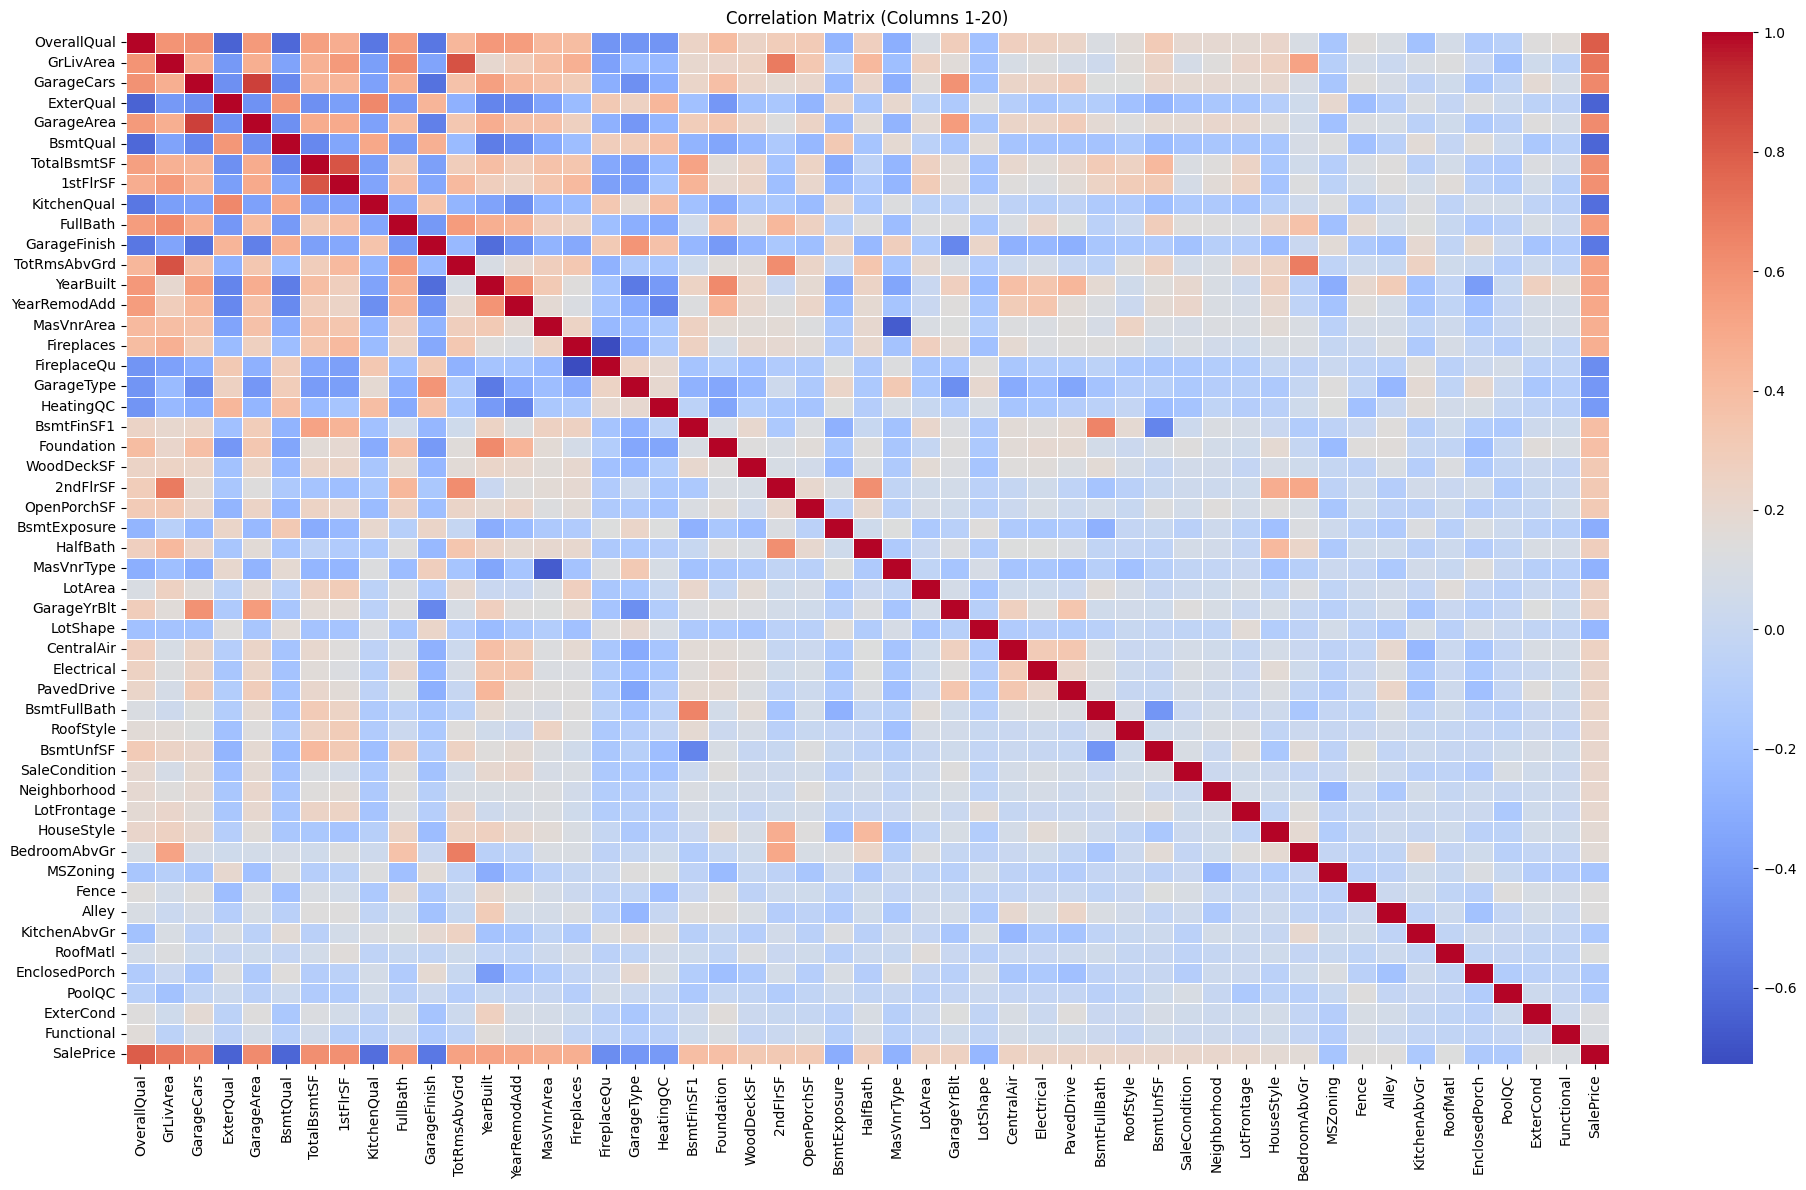

In [730]:
correlation_names = np.concatenate((most_correlated_features[:50],['SalePrice']))
plt.figure(figsize=(20, 12))

sns.heatmap(
    correlation_matrix.loc[correlation_names, correlation_names],
    annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5,
    xticklabels=correlation_names, yticklabels=correlation_names,
)
plt.title('Correlation Matrix (Columns 1-20)')
plt.tight_layout()
plt.show()


In [731]:
# class TudisFeatureExtractor(BaseEstimator, TransformerMixin):
#     def __init__(self, features= None, features_no=1):
#         self.features = features 
#         self.features_no = features_no
       
#     def fit(self, X,):
#         return self
    
#     def transform(self, X):
#         X = pd.DataFrame(X,columns=self.features)
#         X = X.drop(columns=['Id','SalePrice'])
#         return X.to_numpy()

In [734]:
pip = Pipeline([
    ('preprocessor',preprocessor),
], 
verbose=True
)

X_train = pip.transform(train)

(1460, 79)


## 3.2 Train Vadlidation Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, train['SalePrice'].values, test_size=0.1, shuffle=True,random_state=seed)
# y_train = train['SalePrice'].values

## 3.3 Feature importance

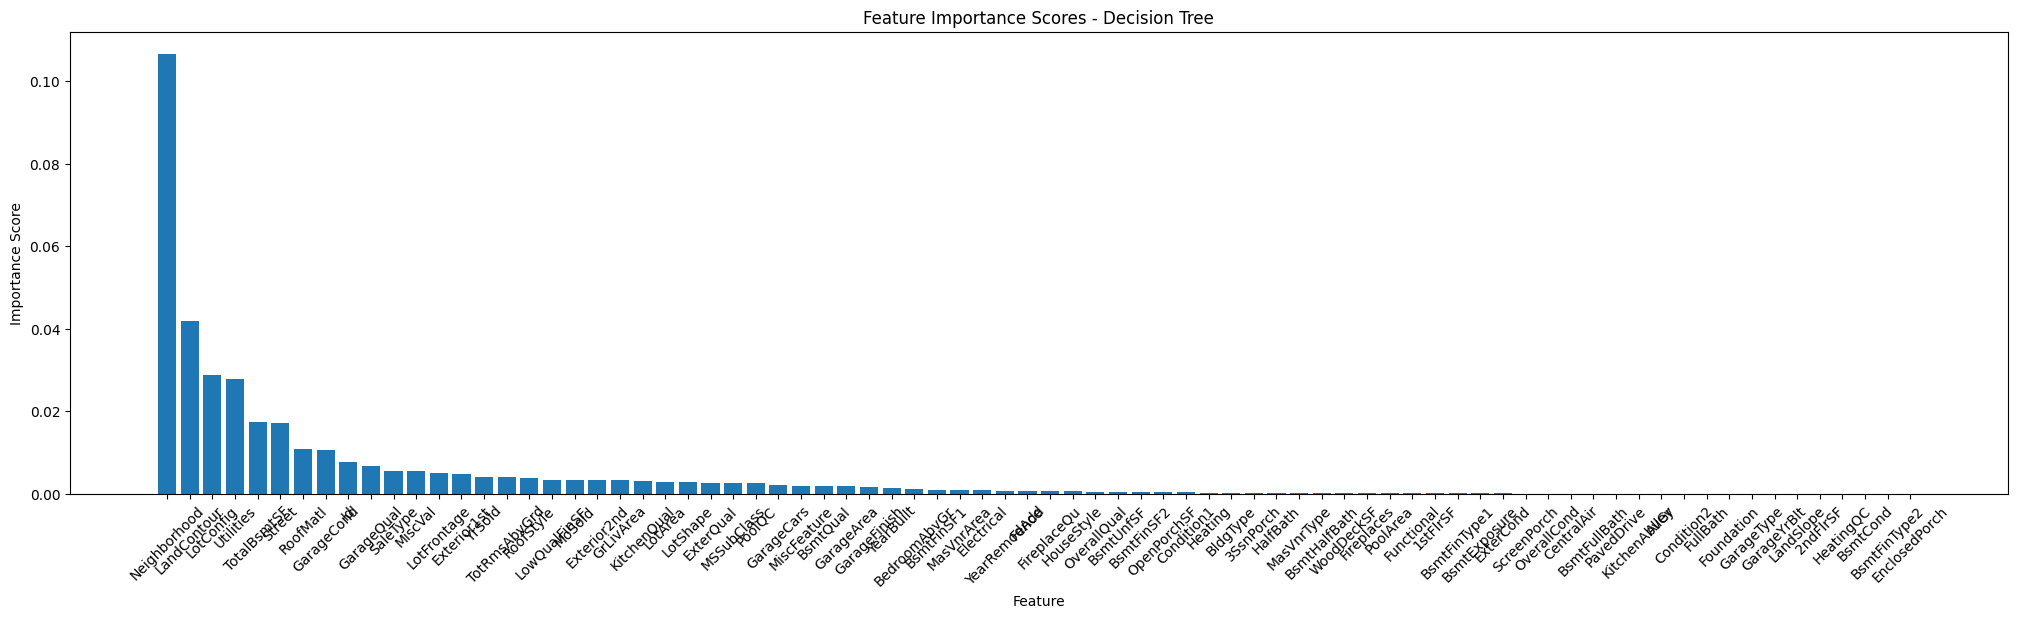

In [ ]:
tree_model = DecisionTreeRegressor(random_state=seed)

tree_model.fit(X_train, y_train)
feature_importances = tree_model.feature_importances_

indices = feature_importances.argsort()[::-1]

plt.figure(figsize=(25, 6))
plt.bar(range(X_train.shape[1]-1), feature_importances[indices[1:]], align="center")
plt.xticks(range(X_train.shape[1]-1), train.columns[indices[1:]], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance Scores - Decision Tree")
plt.show()

## 3. Model selection

In [ ]:
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
models = {
    'XGB': XGBRegressor(random_state=seed),
    'GB': GradientBoostingRegressor(random_state=seed),
    'LGB': LGBMRegressor(random_state=seed),
}


param_grids = {

    'XGB': {
        'max_depth': [3],
        'learning_rate': [0.06],
        'n_estimators': [270],
        'eval_metric': ['rmse'],
        'tree_method': ['exact'],
        'sampling_method':['uniform'],
        'subsample': [0.7],
        'colsample_bytree': [0.9],
        'reg_lambda': [0.2],
    },
    'GB': {
        'loss': ['huber'],
        'learning_rate': [0.07],
        'n_estimators' :[270],
        'max_depth':[3]
    },
    'LGB': {
        'num_leaves': [31],
        'learning_rate':[0.08],
        'n_estimators': [100],
        'objective': ['regression_l1'],
        'force_col_wise': [True],
        'boost': ['gbdt'],
        'subsample_for_bin':[800],
        'colsample_bytree': [0.9],
        'reg_lambda': [0.1],
    }
}


## 4.1 Scoring method

In [ ]:
def root_mean_squared_log_error(y_true, y_pred):
    log1p_true = np.log1p(y_true)
    log1p_pred = np.log1p(y_pred)
    
    squared_log_errors = (log1p_true - log1p_pred) ** 2
    mean_squared_log_error = np.mean(squared_log_errors)
    
    return np.sqrt(mean_squared_log_error)

In [ ]:
best_models = {}
best_score = float('inf')
best_model = None 
custom_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)

In [ ]:
import contextlib

for model_name, model in models.items():
    param_grid = param_grids[model_name]

    with contextlib.redirect_stdout(None):
        grid_search = GridSearchCV(
            model,
            param_grid,
            cv=10,
            scoring=custom_scorer,
            verbose=False,
            return_train_score=True,
        )

        grid_search.fit(X_train, y_train)
        cv_results = grid_search.cv_results_

    best_models[model_name] = grid_search.best_estimator_

    # pretty-print model configurations
    print("=" * 170)
    for i, params in enumerate(cv_results['params']):
        score = abs(cv_results['mean_test_score'][i])
        print(f"[{model_name}]:\t{score}\t\t{params}\t")

[XGB]:	0.12743260091418793		{'colsample_bytree': 0.9, 'eval_metric': 'rmse', 'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 270, 'reg_lambda': 0.2, 'sampling_method': 'uniform', 'subsample': 0.7, 'tree_method': 'exact'}	


KeyboardInterrupt: 

In [ ]:
ensemble_clf = VotingRegressor(
    estimators=[
        ('GB',best_models['GB']),
        ('XGB',best_models['XGB']),
        # ('LGB',best_models['LGB']),
    ],
    # weights=[0.35, 0.34,0.31],
    verbose=True
)

param_grid_clf = {
    'weights': [
        [0.36, 0.34, 0.30], 
        [0.35, 0.34, 0.31], 
        [0.34, 0.33, 0.33], 
               ],
}

In [ ]:
# grid_search_ensemble = GridSearchCV(
#     ensemble_clf,
#     param_grid_clf,
#     cv=5,
#     scoring=custom_scorer,
#     verbose=False,  
#     n_jobs=-1,  
# )

# grid_search_ensemble.fit(X_train, y_train)
# cv_results = grid_search_ensemble.cv_results_

# print("=" * 170)
# for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
#     print(f"[{params}]:\t\t{abs(mean_score)}")

In [ ]:
ensemble_clf.fit(X_train,y_train)

In [ ]:
y_pred = ensemble_clf.predict(X_val)
rMSE = root_mean_squared_log_error(y_val,y_pred)
print("[rMSE]:\t\t", rMSE)

In [ ]:
X_test = pip.transform(test)
test_preds = ensemble_clf.predict(X_test)

## 4. Metrics

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(y_val[:100], alpha=0.5, label='Validation Ground truth',color='red',linewidth=2)
plt.plot(y_pred[:100], alpha=0.5, label='Validation Predicted',color='blue',linewidth=2)
plt.xlabel('Real Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(y_val[40:80], alpha=0.5, label='Validation Ground truth',color='red',linewidth=2)
plt.plot(y_pred[40:80], alpha=0.5, label='Validation Predicted',color='blue',linewidth=2)
plt.xlabel('Real Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## KAGGLE

In [ ]:
submission_data = np.column_stack((test.iloc[:,0],test_preds))
np.savetxt('kaggle.csv', submission_data, delimiter=',', header='Id,SalePrice', fmt='%d,%.4f', comments='')